<a href="https://colab.research.google.com/github/indhu68/AppliedML_Project/blob/main/AppliedML_Improved_Autoencoder_200dbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import time
import random
print("Using tensorflow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
if len(gpus) == 0:
    print("No GPU devices found.")
else:
    for gpu in gpus:
        print(f"GPU found: {gpu.name}")

import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Using tensorflow version: 2.15.0
Num GPUs Available: 1
GPU found: /physical_device:GPU:0


In [ ]:

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import math
pi = tf.constant(np.pi, dtype=tf.float32)

In [ ]:

print(np.version)
print("Using tensorflow version:", tf.__version__)
print(np.__version__)

<module 'numpy.version' from '/usr/local/lib/python3.10/dist-packages/numpy/version.py'>
Using tensorflow version: 2.15.0
1.25.2


In [ ]:

batch_size = 300000

M = 256

# tr is a random uniform distribution of numbers between 1 and M, with the length of the vector being the batch size


tr = np.floor(np.random.uniform(1,M, batch_size))
print(tr)
print(np.size(tr))
rp1 = np.arange(1,M)
rp2 = np.flip(np.arange(1,M))
replacements = dict(zip(rp1,rp2))
print(rp2)
replacer = replacements.get


print(tr)

s_ind = {}
for j in range(1,M):
  s_ind[j] = [i for i, x in enumerate(tr) if x == j]
print(s_ind)
k = 8       # Number of information bits per message, i.e., M=2**k
n = 4       # Number of real channel uses per message
seed = 42    # Seed RNG reproduce identical results


f = 5.9*10**9;#in Hz corresponding to IEEE 802.11p
lamda = 0.05;  #in metres
Pt = 1; #BS transmitted power in watts

BW = 10*10**6; #in Hz
PLE = 2.8; #Path Loss exponent
Beta = {}
Pr = {}
SNR_var = {}
ad_noise_SNR = []  #The values of the dictionary, finally providing an array of stdevs
NoW = 0.02

Transmitted_Power =  23.010299957 #in dBm
Noise_val = 95 #in -dBm

noise = Transmitted_Power + Noise_val


s = np.floor(np.random.uniform(1,M, batch_size))
s = s.astype('int64')

std_shadow = 3
rand1 = np.random.normal(0,std_shadow,batch_size)
for i in range(batch_size):
  Beta[i] = 10*(np.log10(lamda/((4*np.pi*s[i])**PLE)))
  SNR_var[i] = Beta[i] + noise + rand1[i]

for i in SNR_var.values():
  ad_noise_SNR.append(i)
print(np.shape(ad_noise_SNR))
ad_noise_SNR = np.transpose(np.tile(ad_noise_SNR, (2,2,1)))
print(np.shape(ad_noise_SNR))

rand2 = np.random.normal(0,std_shadow,batch_size)
for j in range(1,M):
  Beta[j] = 10*(np.log10(lamda/((4*np.pi*j)**PLE)))
  SNR_var[j] = Beta[j] + noise + rand2[j]

const_noise_SNR = []  #The values of the dictionary, finally providing an array of stdevs
for j in SNR_var.values():
  const_noise_SNR.append(j)
const_noise_SNR = np.transpose(np.tile(const_noise_SNR, (2,2,1)))


#Choosing 15dB SNR as the constant SNR for the TB Approach
seven_noise_SNR = np.add(np.ones(batch_size)*7, np.random.normal(0,3,batch_size))

seven_noise_SNR = np.transpose(np.tile(seven_noise_SNR, (2,2,1)))

tr_noise_SNR = []
rand3 = np.random.normal(0,std_shadow,batch_size)

for i in range(batch_size):
  Beta[i] = 10*(np.log10(lamda/((4*np.pi*tr[i])**2.8)))
  SNR_var[i] = Beta[i] + noise + rand3[i]
for i in SNR_var.values():
  tr_noise_SNR.append(i)

tr_noise_SNR = np.transpose(np.tile(tr_noise_SNR, (2,2,1)))



[114. 205. 239. ...  14. 129.  63.]
300000
[255 254 253 252 251 250 249 248 247 246 245 244 243 242 241 240 239 238
 237 236 235 234 233 232 231 230 229 228 227 226 225 224 223 222 221 220
 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202
 201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186 185 184
 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166
 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148
 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 132 131 130
 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112
 111 110 109 108 107 106 105 104 103 102 101 100  99  98  97  96  95  94
  93  92  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76
  75  74  73  72  71  70  69  68  67  66  65  64  63  62  61  60  59  58
  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40
  39  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22
  21  20

In [ ]:
from keras import layers
from keras import activations
class AE(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())
        self.graph = None
        self.sess = None
        self.vars = None
        self.saver = None
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        #self.weight_var_rec = tf.Variable(tf.random.normal([M, M]), name="weight_var_rec")
        if filename is not None:
            self.load(filename)
        return


    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()
        with self.graph.as_default():
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())

            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,2,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            x = self.encoder(s)

            # Channel
            noise_std = tf.placeholder(tf.float32, shape=[300000,2,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)


            fade = 1
            y = tf.multiply(x,fade) + noise


            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)


            # Loss function

            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(0))

            #Defining the i_matrix
            limit = 256
            i = tf.range(limit)
            multiply = tf.constant([300000])
            i_matrix = tf.reshape(tf.tile(i, multiply), [ multiply[0], tf.shape(i)[0]])
            print(i_matrix)
            e_si = tf.math.square((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)))
            e_si = tf.transpose(e_si)
            b = tf.nn.softmax(s_hat)

            cost_func = tf.math.multiply(b,e_si)

            sum_cf = tf.math.multiply( tf.math.sqrt(tf.reduce_sum(cost_func, axis = 1) + 0.000001 ), (tf.cast(1/(s+ 1), tf.float32)))


            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy + sum_cf)


            # References to graph variables we need to access later
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }
            self.saver = tf.train.Saver()
        return

    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.vars['init'])
        return
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        x = tf.layers.dense(x, self.n, activation=None)

        x = tf.layers.BatchNormalization()(x)
        x = tf.layers.Dropout(0.25)(x)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
        return x

    def decoder(self, input):
        '''The Receiver'''
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.BatchNormalization()(y)
        y = tf.layers.Dropout(0.25)(y)
        print(y);
        return y


    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)

    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }

    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)

    def plot_constellation(self, noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image

    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)

    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler

    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0))
        #print(self.sess.run(self.vars['correct_s_hat'], feed_dict={self.vars['s']: input_s}))

    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s, lr=0))

    def train_validate(self, training_params, validation_params):

        '''Training and validation loop'''
        for index, params in enumerate(training_params):
            s,batch_size, lr, ebnodb, iterations = params
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))

            val_size, val_ebnodb, val_steps = validation_params[index]

            for i in range(iterations):

                self.train_step(s,batch_size, ebnodb, lr)
                if (i%val_steps==0):
                    #bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_new_feed_dict(val_size, val_ebnodb, lr, s_input))
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)
        return

    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        #self.sess.run(self.vars['train_op'], feed_dict=self.gen_new_feed_dict(batch_size, ebnodb, lr, s_input))
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return

    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out))
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER

    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          #for ebnodb in ebnodbs:
            #print(s, batch_size, ebnodb)
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])

          BLER = BLER + bler/iterations
        return BLER


    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image


In [ ]:

train_EbNodB = ad_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #input, batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
    ]

validation_params = [
    #batch_size, ebnodb, val_steps
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file_uw = 'models/ae_k_{}_n_{}'.format(k,n)
ae = AE(k,n,seed)
ae.train_validate(training_params, validation_params)
ae.save(model_file_uw);
ae = AE(k,n,seed, filename=model_file_uw)
ae_uw = AE(k,n,seed, filename=model_file_uw)


Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)


<ipython-input-5-ac2b3cb8ed63>:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
<ipython-input-5-ac2b3cb8ed63>:117: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
<ipython-input-5-ac2b3cb8ed63>:118: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.n, activation=None)
<ipython-input-5-ac2b3cb8ed63>:131: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, self.M, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)

Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(300000, 256), dtype=int32)

Batch Size: 300000, Learning Rate: 0.01, EbNodB: [[[28.67483984 28.67483984]
  [28.67483984 28.67483984]]

 [[10.07103978 10.07103978]
  [10.07103978 10.07103978]]

 [[11.071335   11.071335  ]
  [11.071335   11.071335  ]]

 ...

 [[35.68049218 35.68049218]
  [35.68049218 35.68049218]]

 [[ 7.79565723  7.79565723]
  [ 7.79565723  7.79565723]]

 [[27.14954106 27.14954106]
  [27.14954106 27.14954106]]], Iterations: 10000
0.99427664
0.08971667
0.09767997
0.100266695
0.09401667
0.09289664
0.09420669
0.0886367
0.08907664
0.092223346
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(300000, 256), dtype=int32)
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 

In [ ]:

class AE_Weighted(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())
        self.graph = None
        self.sess = None
        self.vars = None
        self.saver = None
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:
            self.load(filename)
        return


    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()
        with self.graph.as_default():
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())

            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,2,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            x = self.encoder(s)

            # Channel
            noise_std = tf.placeholder(tf.float32, shape=[300000,2,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)


            fade = 1
            y = tf.multiply(x,fade) + noise


            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)


            # Loss function

            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat, weights= (s+1)**(1))

            #Defining the i_matrix
            limit = 256
            i = tf.range(limit)
            multiply = tf.constant([300000])
            i_matrix = tf.reshape(tf.tile(i, multiply), [ multiply[0], tf.shape(i)[0]])
            print(i_matrix)
            e_si = tf.math.square((tf.cast(s, tf.float32)) - tf.transpose(tf.cast(i_matrix,tf.float32)))
            e_si = tf.transpose(e_si)
            b = tf.nn.softmax(s_hat)

            cost_func = tf.math.multiply(b,e_si)

            sum_cf = tf.math.multiply( tf.math.sqrt(tf.reduce_sum(cost_func, axis = 1) + 0.000001 ), (tf.cast(1/(s+ 1), tf.float32)))


            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy + sum_cf)


            # References to graph variables we need to access later
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }
            self.saver = tf.train.Saver()
        return

    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.vars['init'])
        return
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        x = tf.layers.dense(x, self.n, activation=None)

        x = tf.layers.BatchNormalization()(x)
        x = tf.layers.Dropout(0.25)(x)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
        return x

    def decoder(self, input):
        '''The Receiver'''
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.BatchNormalization()(y)
        y = tf.layers.Dropout(0.25)(y)
        print(y);
        return y


    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)

    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }

    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)

    def plot_constellation(self, noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image

    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)

    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler

    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s,lr=0))

    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s,lr=0))


    def train(self, training_params, validation_params):

        '''Training and validation loop'''
        for index, params in enumerate(training_params):
            s,batch_size, lr, ebnodb, iterations = params
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))

            val_size, val_ebnodb, val_steps = validation_params[index]

            for i in range(iterations):
                self.train_step(s,batch_size, ebnodb, lr)
                if (i%val_steps==0):
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)
        return

    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return

    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out))
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER



    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])

          BLER = BLER + bler/iterations
        return BLER

    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

In [ ]:
train_EbNodB = ad_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
#    [10000 , 0.001, train_EbNodB, 10000]
    ]

validation_params = [
    #batch_size, ebnodb, val_steps
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file = 'models/ae_k_{}_n_{}'.format(k,n)
ae_Weighted = AE_Weighted(k,n,seed)
ae_Weighted.train(training_params, validation_params)
ae_Weighted.save(model_file);
ae_Weighted = AE_Weighted(k,n,seed, filename=model_file)

Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(300000, 256), dtype=int32)


<ipython-input-7-1750994fcb9c>:113: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
<ipython-input-7-1750994fcb9c>:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
<ipython-input-7-1750994fcb9c>:115: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.n, activation=None)
<ipython-input-7-1750994fcb9c>:128: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, self.M, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)


Batch Size: 300000, Learning Rate: 0.01, EbNodB: [[[28.67483984 28.67483984]
  [28.67483984 28.67483984]]

 [[10.07103978 10.07103978]
  [10.07103978 10.07103978]]

 [[11.071335   11.071335  ]
  [11.071335   11.071335  ]]

 ...

 [[35.68049218 35.68049218]
  [35.68049218 35.68049218]]

 [[ 7.79565723  7.79565723]
  [ 7.79565723  7.79565723]]

 [[27.14954106 27.14954106]
  [27.14954106 27.14954106]]], Iterations: 10000
0.98498
0.09899336
0.11379999
0.12684333
0.08802998
0.09438336
0.10075003
0.10859001
0.11397332
0.12065333
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(300000, 256), dtype=int32)


In [ ]:

class AE_Tb(object):
    def __init__(self, k, n, seed=None, filename=None):
        assert (n%2 == 0), "Channel only allows complex symbols -> n must be a multiple of 2"
        self.k = k
        self.n = n
        self.n_complex = int(self.n/2)
        self.bits_per_symbol = self.k/self.n_complex
        self.M = 2**self.k
        self.seed = seed if (seed is not None) else int(time.time())
        self.graph = None
        self.sess = None
        self.vars = None
        self.saver = None
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        if filename is not None:
            self.load(filename)
        return


    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()
        with self.graph.as_default():
            tf.set_random_seed(self.seed)
            batch_size = tf.placeholder(tf.int32, shape=())

            # Transmitter
            s = (tf.random_uniform(shape=[batch_size], minval=0, maxval=self.M, dtype=tf.int64))

            ad_noise_std = tf.random_uniform(shape=[batch_size], minval=0, maxval=M, dtype=tf.int64)
            ones = tf.ones([2,2,1],dtype=tf.int64)
            ad_noise_std = tf.transpose(ad_noise_std*ones)
            x = self.encoder(s)

            # Channel
            noise_std = tf.placeholder(tf.float32, shape=[300000,2,2])
            noise = tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)

            fade = tf.random.normal(shape=tf.shape(x))
            sparr1,sparr2 = tf.split(fade,num_or_size_splits=2, axis=2)
            complex_fade = tf.complex(sparr1, sparr2)
            fade = tf.abs(complex_fade)


            fade = 1
            y = tf.multiply(x,fade) + noise


            # Receiver
            s_hat = self.decoder(y)
            correct_s_hat = tf.argmax(tf.nn.softmax(s_hat), axis=1)


            # Loss function

            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)


            correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(s_hat), axis=1), s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1-accuracy

            lr = tf.placeholder(tf.float32, shape=()) # We can feed in any desired learning rate for each step
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)


            # References to graph variables we need to access later
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'correct_s_hat': correct_s_hat,
                'x': x,
            }
            self.saver = tf.train.Saver()
        return

    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.vars['init'])
        return
    def encoder(self, input):
        '''The transmitter'''
        self.weight_var_rec = self.weight_variable((self.M,self.M)) # shape = (8,8)
        self.embedding_lookup_rec = tf.nn.embedding_lookup(self.weight_var_rec, input)
        print(self.embedding_lookup_rec)
        x = tf.nn.elu(self.embedding_lookup_rec)
        x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
        x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        x = tf.layers.dense(x, self.n, activation=None)

        x = tf.layers.BatchNormalization()(x)
        x = tf.layers.Dropout(0.25)(x)
        x = tf.reshape(x, shape=[-1,self.n_complex,2])
        print(x);
        #Average power normalization
        x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
        return x

    def decoder(self, input):
        '''The Receiver'''
        y = tf.reshape(input, shape=[-1,self.n])
        y = tf.layers.dense(y, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.dense(y, self.M, activation=None)
        y = tf.layers.BatchNormalization()(y)
        y = tf.layers.Dropout(0.25)(y)
        print(y);
        return y


    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10**(ebnodb/10)
        return 1/np.sqrt(2*self.bits_per_symbol*ebno)

    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def gen_e2e_feed_dict(self, batch_size, ebnodb, s_input, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['s']: s_input,
            self.vars['lr']: lr,
        }

    def load(self, filename):
        '''Load an pre_trained model'''
        return self.saver.restore(self.sess, filename)

    def plot_constellation(self,arr,noise_std, maxrange=None):
        '''Generate a plot of the current constellation'''
        x = self.transmit(range(self.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(self.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-maxrange,maxrange)
            plt.ylim(-maxrange,maxrange)
            for i in range(self.M):
              if (i <=150):
                plt.scatter(x[i,k,0],x[i,k,1],c="black")
              if (i > 150):
                plt.scatter(x[i,k,0],x[i,k,1],c="red")
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image

    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)

    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler

    def transmit(self, s, noise_std):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['x'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})

    def end2end(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['correct_s_hat'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s,lr=0))

    def end2end_bler(self, batch_size, ebnodb, input_s):
        '''Returns the transmitted sigals corresponding to message indices'''
        return self.sess.run(self.vars['bler'], feed_dict=self.gen_e2e_feed_dict(batch_size, ebnodb, input_s,lr=0))


    def train(self, training_params, validation_params):

        '''Training and validation loop'''
        for index, params in enumerate(training_params):
            s,batch_size, lr, ebnodb, iterations = params
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations))

            val_size, val_ebnodb, val_steps = validation_params[index]

            for i in range(iterations):

                self.train_step(s,batch_size, ebnodb, lr)
                if (i%val_steps==0):
                    bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                    print(bler)
        return

    def train_step(self,s, batch_size, ebnodb, lr):
        '''A single training step'''
        self.sess.run(self.vars['train_op'], feed_dict={self.vars['s']: s, self.vars['batch_size']: batch_size,  self.vars['noise_std']: self.EbNo2Sigma(ebnodb), self.vars['lr']: lr})
        return

    def weight_variable(self, shape):
        '''Xavier-initialized weights optimized for ReLU Activations'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0/(fan_in + fan_out))
        high = -np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER



    def bler_sim1(self,s,  ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No
           Sometimes we to compute statistics for batch sizes that do not fit into the GPUs memory.
           You can average over multiple batches with small size instead.
        '''
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
          bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_e2e_feed_dict(batch_size, np.transpose(np.tile(np.ones(1000)*ebnodb, (2,2,1))), s, lr=0)) for ebnodb in ebnodbs])

          BLER = BLER + bler/iterations
        return BLER

    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5,1])
        return image

In [ ]:
train_EbNodB = seven_noise_SNR
val_EbNodB = train_EbNodB

lr = 0.01

epoch = [10000]

training_params = [
    #batch_size, lr, ebnodb, iterations
    [s, batch_size , 0.01, train_EbNodB, 10000]
    #[s, 1000 , 0.001, train_EbNodB, 10000]
    #[1000 , 0.001, train_EbNodB, 10000]
    ]

validation_params = [
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000],
    [batch_size, val_EbNodB, 1000]
    ]

model_file_Tb = 'models/ae_k_{}_n_{}'.format(k,n)
ae_Tb = AE_Tb(k,n,seed)
ae_Tb.train(training_params, validation_params)
ae_Tb.save(model_file_Tb);
ae_Tb = AE_Tb(k,n,seed, filename=model_file_Tb)


Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)


<ipython-input-9-9239c3029e64>:99: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(self.embedding_lookup_rec, self.M, activation=tf.nn.relu)
<ipython-input-9-9239c3029e64>:100: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
<ipython-input-9-9239c3029e64>:101: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  x = tf.layers.dense(x, self.n, activation=None)
<ipython-input-9-9239c3029e64>:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y = tf.layers.dense(y, self.M, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))
<ipyt


Batch Size: 300000, Learning Rate: 0.01, EbNodB: [[[ 6.80523696  6.80523696]
  [ 6.80523696  6.80523696]]

 [[ 2.08726936  2.08726936]
  [ 2.08726936  2.08726936]]

 [[ 8.83984499  8.83984499]
  [ 8.83984499  8.83984499]]

 ...

 [[ 5.14584905  5.14584905]
  [ 5.14584905  5.14584905]]

 [[12.95100213 12.95100213]
  [12.95100213 12.95100213]]

 [[ 1.54511722  1.54511722]
  [ 1.54511722  1.54511722]]], Iterations: 10000
0.9807133
0.1494
0.15003997
0.14662665
0.1492467
0.1477567
0.14880335
0.14826667
0.14728332
0.14762998
Tensor("embedding_lookup/Identity:0", shape=(?, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 2, 2), dtype=float32)
Tensor("dropout_1/Identity:0", shape=(300000, 256), dtype=float32)


RMSE Calculation

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.057977103565244846, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.8696565534786727, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.6510933906454038, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 1.3275999355779058, 73: 0.7855296660135065, 74: 0.0, 75: 0.2581988897471611, 76: 0.02956561979945413, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 1.7042877410372297, 83: 0.0, 84: 0.0, 85: 0.0, 86: 2.22053202837624, 87: 0.0, 88: 2.658713117188957, 89: 0.0, 90: 0.0, 91: 0.0, 92: 1.1716684759537825, 93: 1.830556463

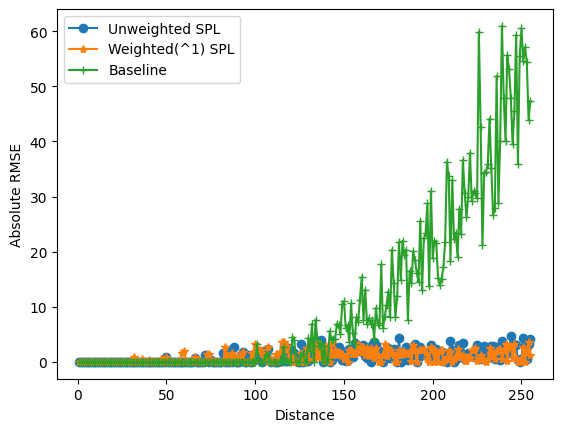

In [ ]:
def rmse(predictions,targets):
  return (np.sqrt((np.subtract(predictions,targets) ** 2).mean()))

iter = 10
rmse_uw = {}
rmse_w = {}
rmse_Tb = {}
sum_uw = {}
sum_w = {}
sum_Tb = {}
sum_uw[0] = 0





tr_hat = ae.end2end(len(tr), tr_noise_SNR, tr)
tr_hat_w = ae_Weighted.end2end(len(tr), tr_noise_SNR, tr)
tr_hat_Tb = ae_Tb.end2end(len(tr), tr_noise_SNR, tr)

for j in range(1,M):
  rmse_uw[j] = rmse(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
 rmse_w[j] = rmse(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
  rmse_Tb[j] = rmse(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))


print(rmse_uw)
message_factor = (np.arange(1, M))

rmse_uwA = []
for i in rmse_uw.values():
  rmse_uwA.append(i)

rmse_wA = []
for i in rmse_w.values():
  rmse_wA.append(i)

rmse_TbA = []
for i in rmse_Tb.values():
  rmse_TbA.append(i)


rmse_uw = rmse_uwA
rmse_w = rmse_wA
rmse_Tb = rmse_TbA

message = np.arange(1,M)

print(rmse_uw)
plt.plot(message, rmse_uw, '-o');
plt.plot(message, rmse_w, '-*');
plt.plot(message, rmse_Tb, '-+');
plt.xlabel('Distance')
plt.ylabel('Absolute RMSE')
plt.legend(['Unweighted SPL', 'Weighted(^1) SPL','Baseline'])

print('Average RMSE:', np.sum(rmse_uw)/M)
print('Average RMSE:',np.sum(rmse_w)/M)
print('Average RMSE:',np.sum(rmse_Tb)/M)



{1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 79: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 0.99998665, 88: 1.0, 89: 0.99013, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 0.9791833, 95: 1.0, 96: 0.99999, 97: 1.0, 98: 1.0, 99: 0.0025299788, 100: 1.0, 101: 1.0, 102: 0.21528333, 103: 0.99998665, 104: 0.6018367, 105: 0.0, 106: 1.

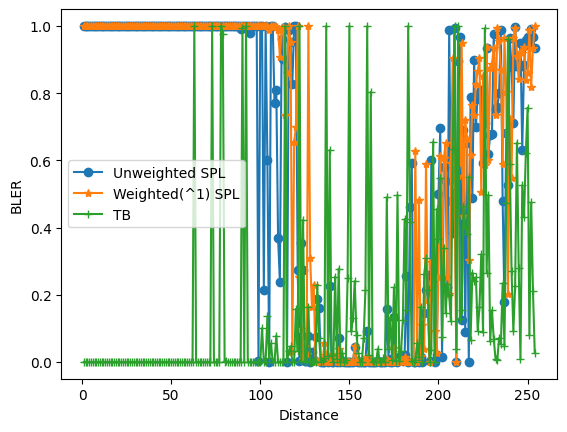

In [ ]:
bler_uw = {}
bler_w = {}
bler_Tb = {}
bler_final_uw = {}
bler_final_w = {}
bler_final_Tb = {}
bler_final_uw_val = []
bler_final_w_val = []
bler_final_Tb_val = []

Beta = {}
SNR_var = {}


for j in range(1,M-1):
    bler_uw[j] = ae.end2end_bler(batch_size, np.tile(const_noise_SNR[j], (batch_size, 1, 1)), j*np.ones(batch_size))
    bler_w[j] = ae_Weighted.end2end_bler(batch_size, np.tile(const_noise_SNR[j], (batch_size, 1, 1)), j*np.ones(batch_size))
    bler_Tb[j] = ae_Tb.end2end_bler(batch_size, np.tile(const_noise_SNR[j], (batch_size, 1, 1)), j*np.ones(batch_size))
print(bler_uw)
print(bler_w)
print(bler_Tb)


bler_final_uw = bler_uw
bler_final_w = bler_w
bler_final_Tb = bler_Tb

for i in bler_final_uw.values():
  bler_final_uw_val.append(i)
for i in bler_final_w.values():
  bler_final_w_val.append(i)

for i in bler_final_Tb.values():
  bler_final_Tb_val.append(i)
message = np.arange(1,M-1)
plt.plot(message, bler_final_uw_val, '-o');
plt.plot(message, bler_final_w_val, '-*');
plt.plot(message, bler_final_Tb_val, '-+');
print(bler_final_Tb_val)
plt.xlabel('Distance')
plt.ylabel('BLER')
plt.legend(['Unweighted SPL', 'Weighted(^1) SPL','TB'])

print(sum(bler_uw))
print(sum(bler_w))
print(sum(bler_Tb))


{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0008403361344537785, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0008403361344537785, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0017590149516271136, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0017271157167529916, 73: 0.0025083612040134318, 74: 0.0, 75: 0.0008230452674896638, 76: 0.0008741258741258306, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0017346053772766545, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0017528483786152238, 87: 0.0, 88: 0.003481288076588318, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0017

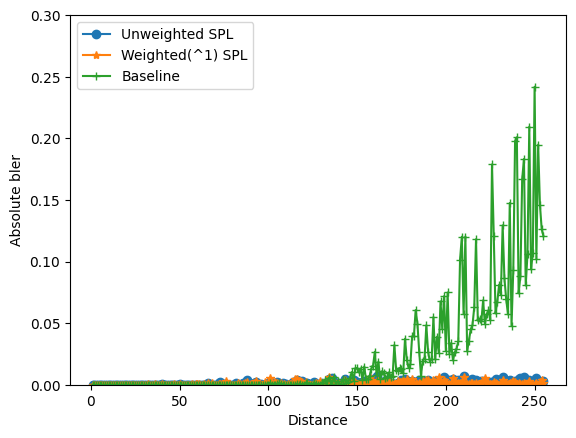

In [ ]:
def nsj_bler(predictions,targets):
  return 1 - (((np.equal(predictions,targets)).mean()))

iter = 10
bler_uw = {}
bler_w = {}
bler_Tb = {}
sum_uw = {}
sum_w = {}
sum_Tb = {}



for j in range(1,M):
  bler_uw[j] = nsj_bler(([tr_hat[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
  bler_w[j] = nsj_bler(([tr_hat_w[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))
for j in range(1,M):
  bler_Tb[j] = nsj_bler(([tr_hat_Tb[x] for x in s_ind[j]]), ([tr[x] for x in s_ind[j]]))

print(bler_uw)
message_factor = (np.arange(1, M))

bler_uwA = []
for i in bler_uw.values():
  bler_uwA.append(i)

bler_wA = []
for i in bler_w.values():
  bler_wA.append(i)

bler_TbA = []
for i in bler_Tb.values():
  bler_TbA.append(i)


bler_uw = bler_uwA


bler_w = bler_wA


bler_Tb = bler_TbA

message = np.arange(1,M)

print(bler_uw)
plt.plot(message, bler_uw, '-o');
plt.plot(message, bler_w, '-*');
plt.plot(message, bler_Tb, '-+');
plt.xlabel('Distance')
plt.ylabel('Absolute bler')
plt.ylim([0, 0.3])
plt.legend(['Unweighted SPL', 'Weighted(^1) SPL','Baseline'])


print('Average BLER:',np.sum(bler_uw)/M)
print('Average BLER:',np.sum(bler_w)/M)
print('Average BLER:',np.sum(bler_Tb)/M)



In [ ]:
import matplotlib.cm as cm
import itertools
def plot_constellation_2(ae, arr, noise_std,  maxrange=None):
        '''Generate a plot of the current constellation'''
        x = ae.transmit(range(ae.M), noise_std)
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        for k in range(ae.n_complex):
            image = plt.figure(figsize=(6,6))
            plt.grid(True)
            plt.xlim(-2,2)
            plt.ylim(-2,2)
            for i in range(ae.M):
              plt.scatter(x[i,k,0],x[i,k,1],color=cm.jet_r(i/255.0))
              #if (i <=150):
                #plt.scatter(x[i,k,0],x[i,k,1],c="black")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))
              #if (i > 150):
                #plt.scatter(x[i,k,0],x[i,k,1],c="red")
                #plt.annotate(i, (x[i,k,0],x[i,k,1]))
                #plt.scatter(x[i,k,0],x[i,k,1],c="black",marker='x')
            image.axes[0].set_xticks(np.array([-2,-1,0,1,2]))
            image.axes[0].set_yticks(np.array([-2,-1,0,1,2]))
            #image.suptitle('%d. complex symbol' % (k+1))
            plt.xlabel('Re')
            plt.ylabel('Im')
        return x, image

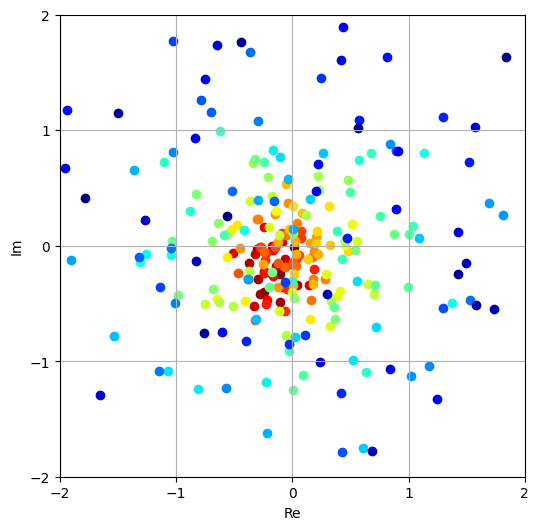

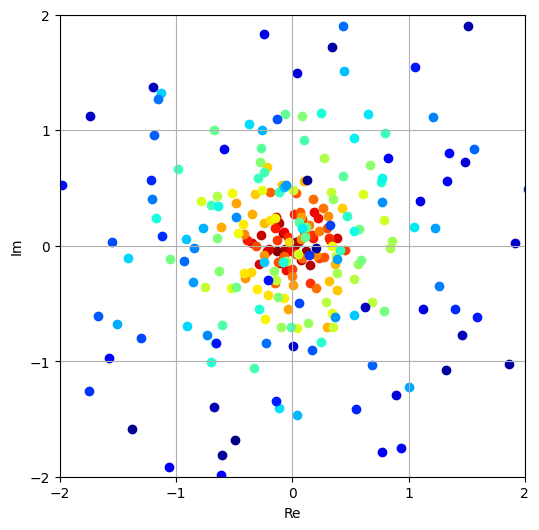

In [ ]:
plot_constellation_2(ae,range(0,ae.M), const_noise_SNR);

(array([[[ 8.4210038e-03, -1.8549966e-02],
         [ 5.8187470e-03,  4.9242251e-02]],
 
        [[ 5.4709423e-02,  8.0219977e-02],
         [-1.8103150e-01, -1.3550727e-02]],
 
        [[ 7.9026952e-02,  1.2125867e-01],
         [-2.4579944e-01, -1.1226677e-03]],
 
        ...,
 
        [[-3.0433834e-01,  2.3575777e-01],
         [-5.5846107e-01, -2.5497212e+00]],
 
        [[-6.6199106e-01,  1.2755477e+00],
         [ 2.1576343e+00, -4.6637616e-01]],
 
        [[ 1.5096949e+00,  1.8271511e+00],
         [ 1.0999706e+00,  5.5074686e-01]]], dtype=float32),
 <Figure size 600x600 with 1 Axes>)

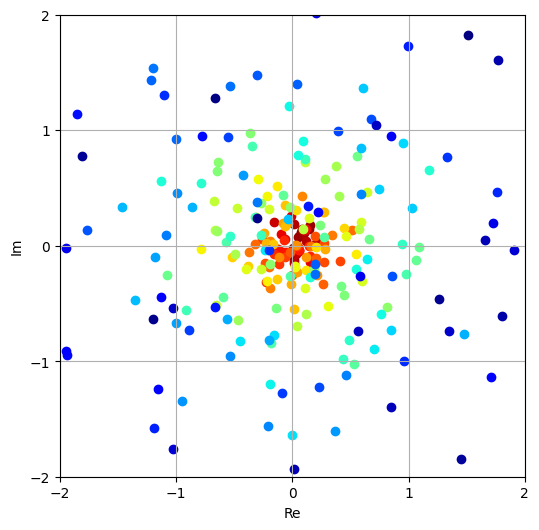

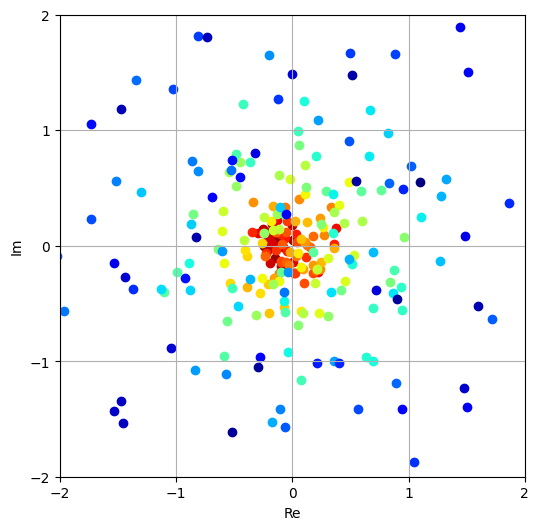

In [ ]:
plot_constellation_2(ae_Weighted,range(0,ae_Weighted.M), const_noise_SNR)

(array([[[ 0.0089227 , -0.06432981],
         [ 0.03460782,  0.05494937]],
 
        [[-0.1634576 , -0.46885106],
         [-0.98934096, -1.1826771 ]],
 
        [[ 0.2529559 , -0.34253174],
         [-0.23818211, -1.2243096 ]],
 
        ...,
 
        [[ 1.3345547 , -0.01189001],
         [-0.55919856,  0.61397266]],
 
        [[ 0.04462235,  0.16742553],
         [ 0.8997008 , -1.2992443 ]],
 
        [[ 0.35851997,  1.219624  ],
         [ 0.86615026,  0.2222244 ]]], dtype=float32),
 <Figure size 600x600 with 1 Axes>)

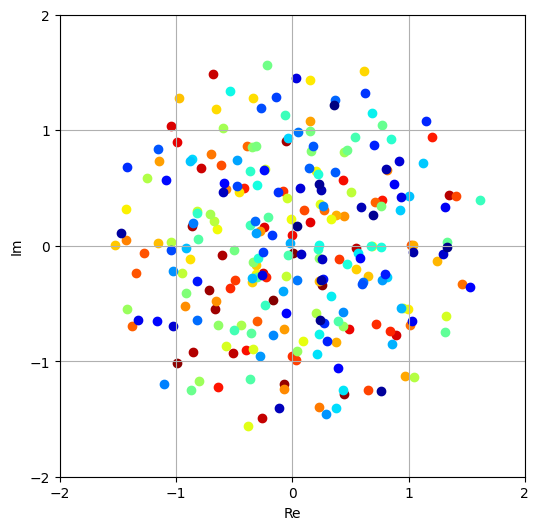

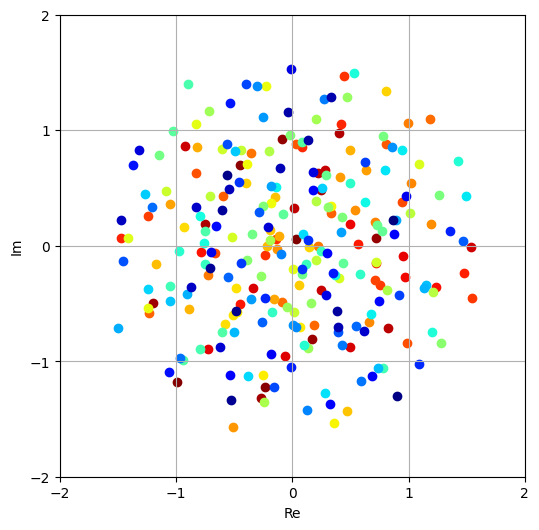

In [ ]:
plot_constellation_2(ae_Tb,range(0,ae_Tb.M), const_noise_SNR)